In [5]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [8]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [9]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [10]:
dataset = SunImageDataset(csv_file="/content/dataset_full_2024_with_cr_6days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size-24]
k_fold_2_indices = indices[fold_size+24:(2*fold_size)-24]
k_fold_3_indices = indices[(2*fold_size)+24:(3*fold_size)-24]
k_fold_4_indices = indices[(3*fold_size)+24:(4*fold_size)-24]
k_fold_5_indices = indices[(4*fold_size)+24:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_2024_with_cr_6days.csv")
kp_dates_list = kp_dates["date"].tolist()

1869
1845
1845
1845
1872


In [11]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_2024_with_cr_6days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

495
634
548
322
615


In [12]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()

        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)

        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [13]:
torch.cuda.empty_cache()

In [14]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [15]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  2.0649499693890254


Validation Progress: Epoch: 1:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.8680369165451465


Training Progress: Epoch: 2:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.6197421420046876


Validation Progress: Epoch: 2:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.180159034510143


Training Progress: Epoch: 3:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.289895771960972


Validation Progress: Epoch: 3:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.012392671474134


Training Progress: Epoch: 4:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.970192861330349


Validation Progress: Epoch: 4:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.2781667739875058


Training Progress: Epoch: 5:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.7391281181652184


Validation Progress: Epoch: 5:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.2818756544058596


Training Progress: Epoch: 6:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.5826309894579756


Validation Progress: Epoch: 6:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.258495081987617


Training Progress: Epoch: 7:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.4785831379112043


Validation Progress: Epoch: 7:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.529177320531806


Training Progress: Epoch: 8:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.3958603572870132


Validation Progress: Epoch: 8:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.268976386447803


Training Progress: Epoch: 9:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.35445463838773844


Validation Progress: Epoch: 9:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.3800851564259236


Training Progress: Epoch: 10:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.30236147319164347


Validation Progress: Epoch: 10:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.4360457586798754


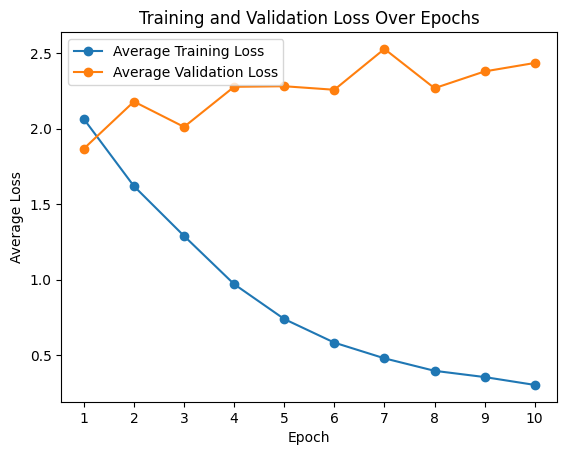

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/935 [00:00<?, ?it/s]

Average test loss: 2.4360
RMSE: 1.5608
MSE: 2.4366
MAE: 1.2289
R²: -0.3187
R: 0.1054
True Skill Score: 0.0521
Accuracy: 0.6314
Precision: 0.2945
Recall: 0.2808
F1 Score: 0.2875


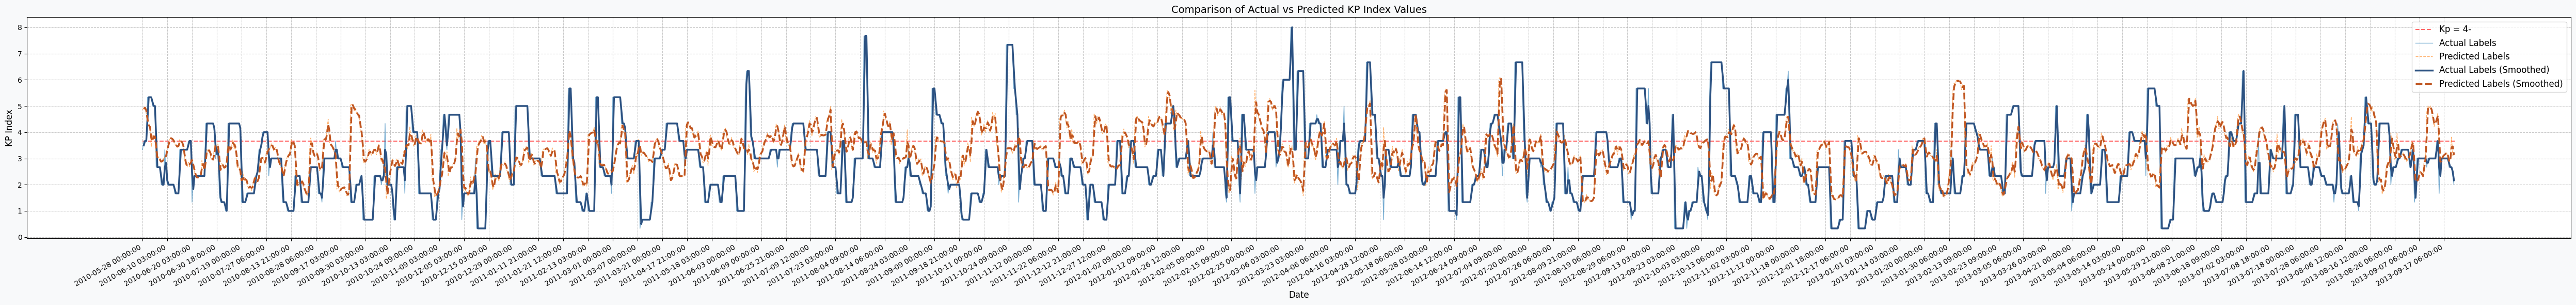

[np.float32(4.84375), np.float32(4.9375), np.float32(4.9375), np.float32(4.71875), np.float32(4.28125), np.float32(4.25), np.float32(4.15625), np.float32(3.4375), np.float32(3.890625), np.float32(3.796875), np.float32(3.859375), np.float32(3.078125), np.float32(2.9375), np.float32(3.0625), np.float32(2.875), np.float32(2.875), np.float32(2.90625), np.float32(3.0), np.float32(3.046875), np.float32(3.140625), np.float32(3.4375), np.float32(3.59375), np.float32(3.78125), np.float32(3.765625), np.float32(3.734375), np.float32(3.65625), np.float32(3.5625), np.float32(3.484375), np.float32(3.421875), np.float32(3.515625), np.float32(3.71875), np.float32(3.625), np.float32(3.609375), np.float32(3.359375), np.float32(2.9375), np.float32(2.75), np.float32(2.671875), np.float32(2.859375), np.float32(2.6875), np.float32(2.984375), np.float32(2.890625), np.float32(2.640625), np.float32(2.484375), np.float32(2.265625), np.float32(2.28125), np.float32(2.265625), np.float32(2.34375), np.float32(2.359

Testing Progress:   0%|          | 0/248 [00:00<?, ?it/s]

Average test loss: 3.3459
RMSE: 1.8292
MSE: 3.3504
MAE: 1.4670
R²: -2.9120
R: -0.0717


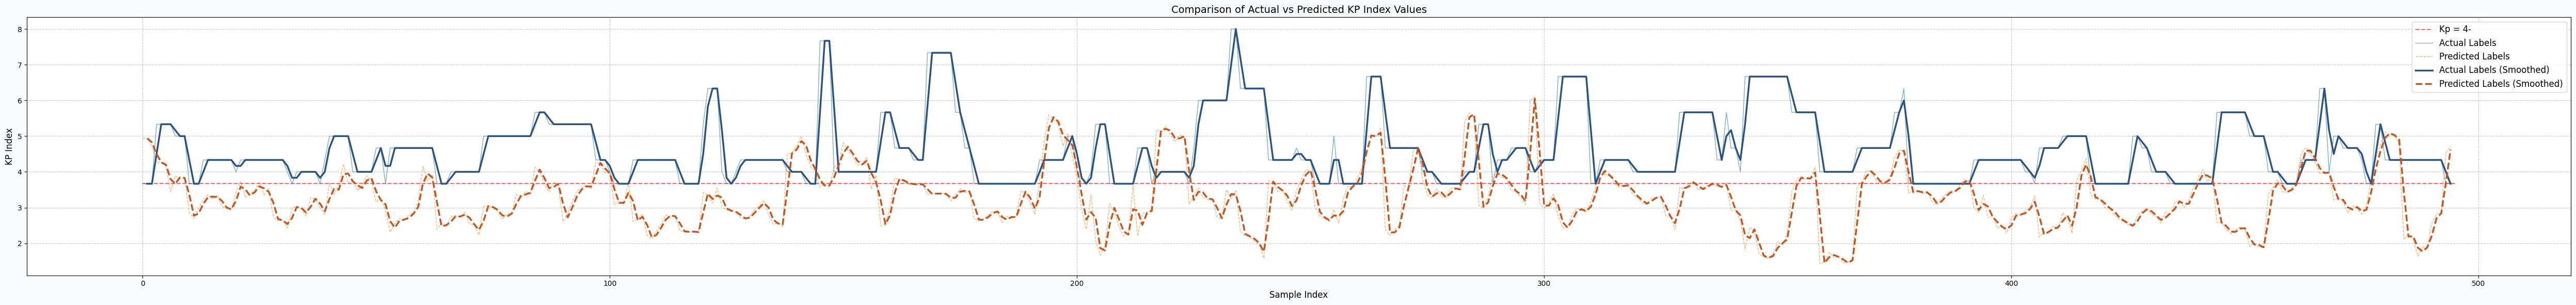

[np.float32(4.9375), np.float32(4.9375), np.float32(4.71875), np.float32(4.28125), np.float32(4.25), np.float32(4.15625), np.float32(3.4375), np.float32(3.890625), np.float32(3.796875), np.float32(3.859375), np.float32(2.859375), np.float32(2.6875), np.float32(2.984375), np.float32(3.21875), np.float32(3.359375), np.float32(3.25), np.float32(3.34375), np.float32(3.03125), np.float32(2.96875), np.float32(2.9375), np.float32(3.4375), np.float32(3.734375), np.float32(3.28125), np.float32(3.390625), np.float32(3.46875), np.float32(3.71875), np.float32(3.359375), np.float32(3.53125), np.float32(2.734375), np.float32(2.625), np.float32(2.65625), np.float32(2.421875), np.float32(3.0), np.float32(3.03125), np.float32(2.953125), np.float32(2.765625), np.float32(3.28125), np.float32(3.21875), np.float32(3.0), np.float32(2.796875), np.float32(3.6875), np.float32(3.359375), np.float32(3.640625), np.float32(4.21875), np.float32(3.6875), np.float32(3.78125), np.float32(3.46875), np.float32(3.625), n

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.969054597574205


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.04449627020198


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.606264343153158


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.0884340564052692


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.3442526380663695


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.8476753020708319


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.0289883139695244


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.5523936494043826


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.797202914881882


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.2601921837495005


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6109985651110375


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.32759632566662


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4981307121701554


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.70171596895084


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4263237213213318


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.2941735381574446


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3878524860482498


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.3520382272806333


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.32399957113515615


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.2430604386598643


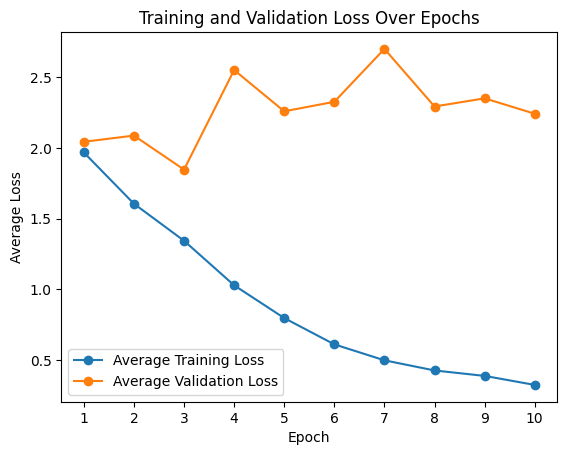

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 2.2431
RMSE: 1.4977
MSE: 2.2421
MAE: 1.1715
R²: -0.1271
R: 0.1842
True Skill Score: 0.4326
Accuracy: 0.6780
Precision: 0.5581
Recall: 0.3028
F1 Score: 0.3926


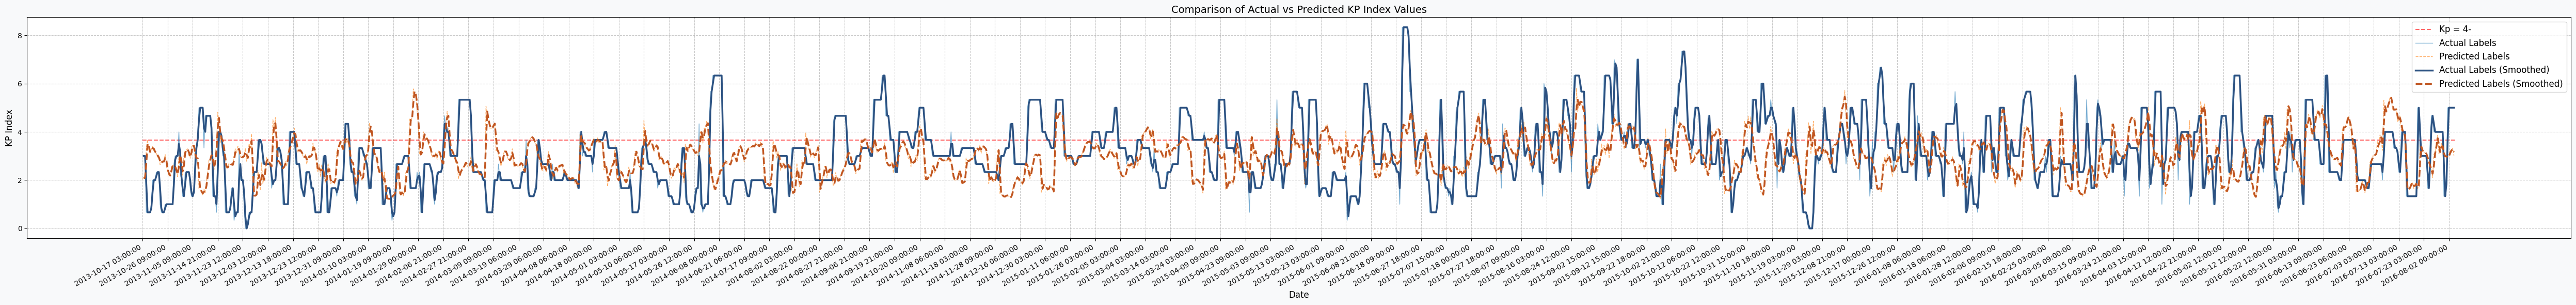

[np.float32(2.046875), np.float32(2.109375), np.float32(2.09375), np.float32(3.328125), np.float32(3.671875), np.float32(3.203125), np.float32(3.140625), np.float32(3.265625), np.float32(3.390625), np.float32(3.21875), np.float32(3.140625), np.float32(3.109375), np.float32(2.953125), np.float32(2.9375), np.float32(2.640625), np.float32(2.78125), np.float32(2.765625), np.float32(2.765625), np.float32(3.0625), np.float32(2.59375), np.float32(2.359375), np.float32(2.203125), np.float32(2.171875), np.float32(2.578125), np.float32(2.59375), np.float32(2.625), np.float32(2.5), np.float32(2.359375), np.float32(2.140625), np.float32(2.984375), np.float32(3.078125), np.float32(2.53125), np.float32(2.203125), np.float32(3.015625), np.float32(3.234375), np.float32(3.25), np.float32(3.296875), np.float32(3.015625), np.float32(2.90625), np.float32(3.359375), np.float32(3.453125), np.float32(3.390625), np.float32(2.859375), np.float32(2.9375), np.float32(2.875), np.float32(1.625), np.float32(1.58593

Testing Progress:   0%|          | 0/317 [00:00<?, ?it/s]

Average test loss: 3.5245
RMSE: 1.8774
MSE: 3.5245
MAE: 1.5401
R²: -3.1836
R: 0.0849


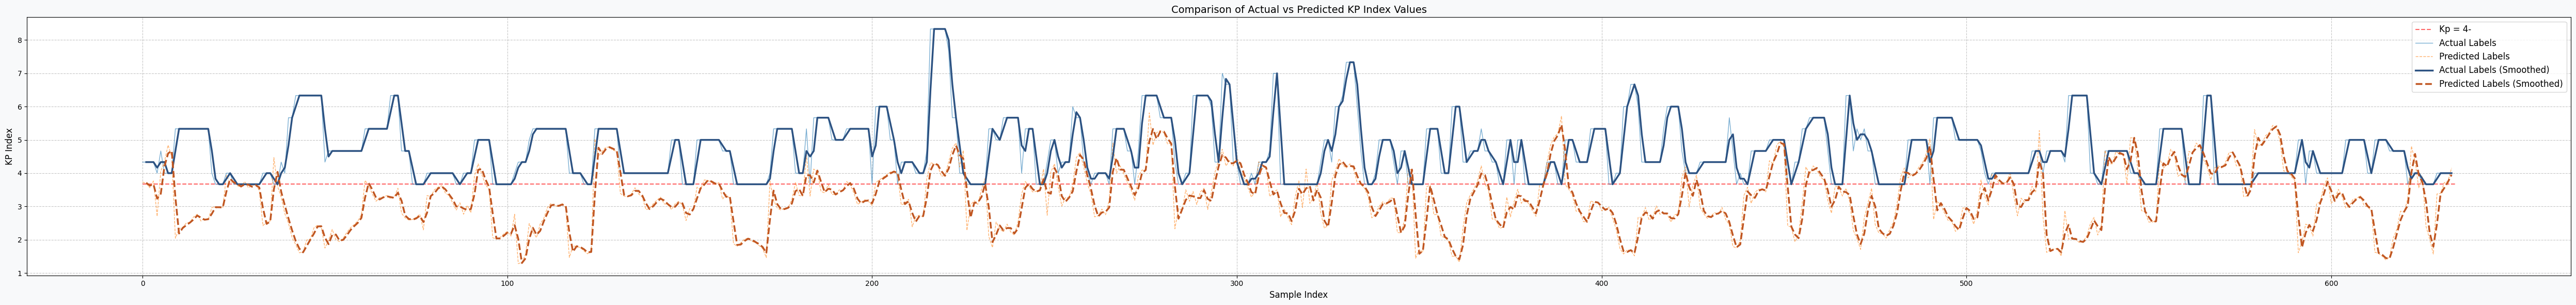

[np.float32(3.734375), np.float32(3.6875), np.float32(3.5625), np.float32(3.765625), np.float32(2.703125), np.float32(4.0625), np.float32(4.34375), np.float32(4.84375), np.float32(4.5), np.float32(2.046875), np.float32(2.328125), np.float32(2.375), np.float32(2.5), np.float32(2.53125), np.float32(2.6875), np.float32(2.765625), np.float32(2.5625), np.float32(2.640625), np.float32(2.59375), np.float32(2.96875), np.float32(2.984375), np.float32(2.96875), np.float32(2.96875), np.float32(3.9375), np.float32(3.71875), np.float32(3.734375), np.float32(3.625), np.float32(3.578125), np.float32(3.75), np.float32(3.5625), np.float32(3.625), np.float32(3.65625), np.float32(3.484375), np.float32(2.421875), np.float32(2.53125), np.float32(2.5625), np.float32(4.46875), np.float32(3.609375), np.float32(3.28125), np.float32(2.78125), np.float32(2.5), np.float32(2.0625), np.float32(1.8515625), np.float32(1.609375), np.float32(1.6328125), np.float32(1.9921875), np.float32(2.015625), np.float32(2.359375),

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  2.0529036392302693


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.7167077458450193


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.6654387721695216


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5283230135785133


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.290526643074107


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.9617583300899548


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.9549936505889646


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.667653293191332


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.7320434850672174


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.572447737708415


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5847821594978769


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.7139533202325774


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.46607297849256674


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6144059334992849


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.41500519551520076


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.741185497121486


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.33235880341649005


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.7390023159917105


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.28632321433020913


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6064002404154913


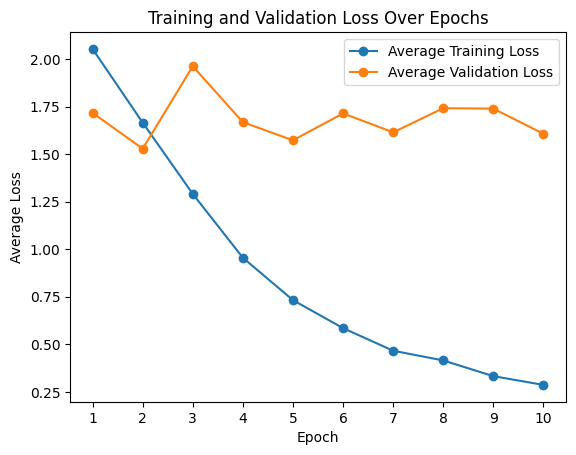

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.6064
RMSE: 1.2674
MSE: 1.6071
MAE: 1.0278
R²: 0.0235
R: 0.2963
True Skill Score: 0.4893
Accuracy: 0.7041
Precision: 0.5147
Recall: 0.0639
F1 Score: 0.1136


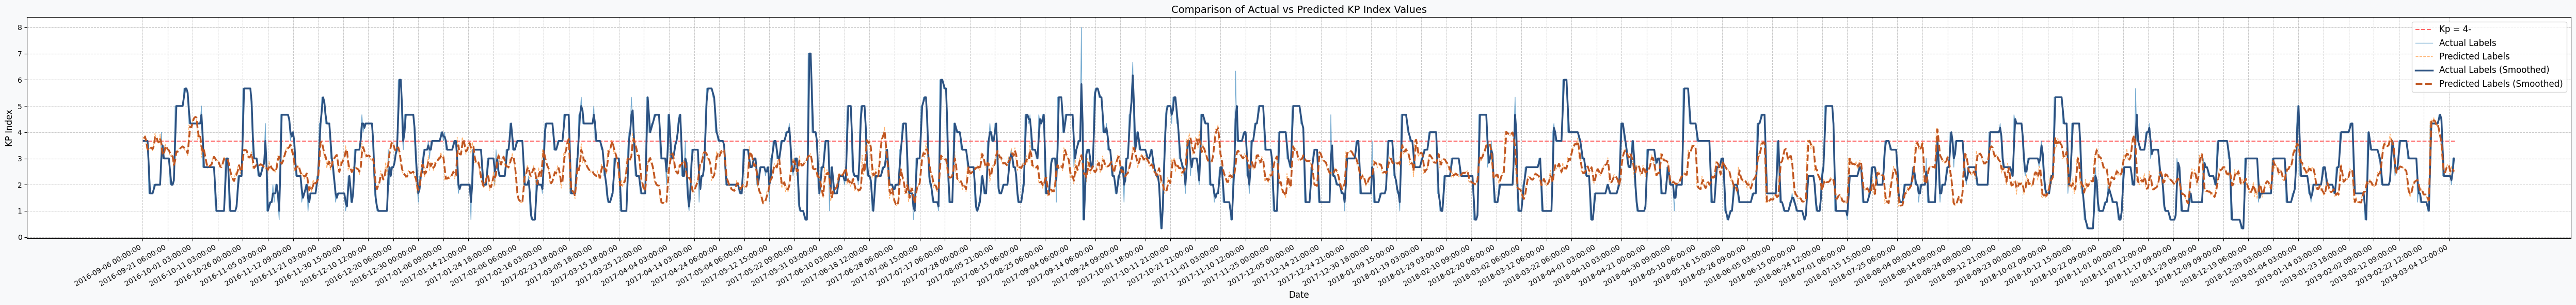

[np.float32(3.75), np.float32(3.78125), np.float32(3.875), np.float32(3.421875), np.float32(3.28125), np.float32(3.328125), np.float32(3.40625), np.float32(3.421875), np.float32(3.28125), np.float32(3.65625), np.float32(3.96875), np.float32(3.71875), np.float32(3.609375), np.float32(3.609375), np.float32(3.921875), np.float32(3.21875), np.float32(3.0625), np.float32(3.234375), np.float32(3.546875), np.float32(3.40625), np.float32(3.296875), np.float32(3.328125), np.float32(3.078125), np.float32(3.140625), np.float32(3.015625), np.float32(2.5), np.float32(3.328125), np.float32(3.203125), np.float32(3.296875), np.float32(3.375), np.float32(3.390625), np.float32(3.453125), np.float32(3.46875), np.float32(3.375), np.float32(3.296875), np.float32(3.28125), np.float32(3.109375), np.float32(4.28125), np.float32(4.15625), np.float32(4.21875), np.float32(4.53125), np.float32(4.53125), np.float32(4.625), np.float32(4.5), np.float32(3.71875), np.float32(3.875), np.float32(3.859375), np.float32(3.

Testing Progress:   0%|          | 0/274 [00:00<?, ?it/s]

Average test loss: 3.1813
RMSE: 1.7836
MSE: 3.1813
MAE: 1.5937
R²: -5.8163
R: 0.2122


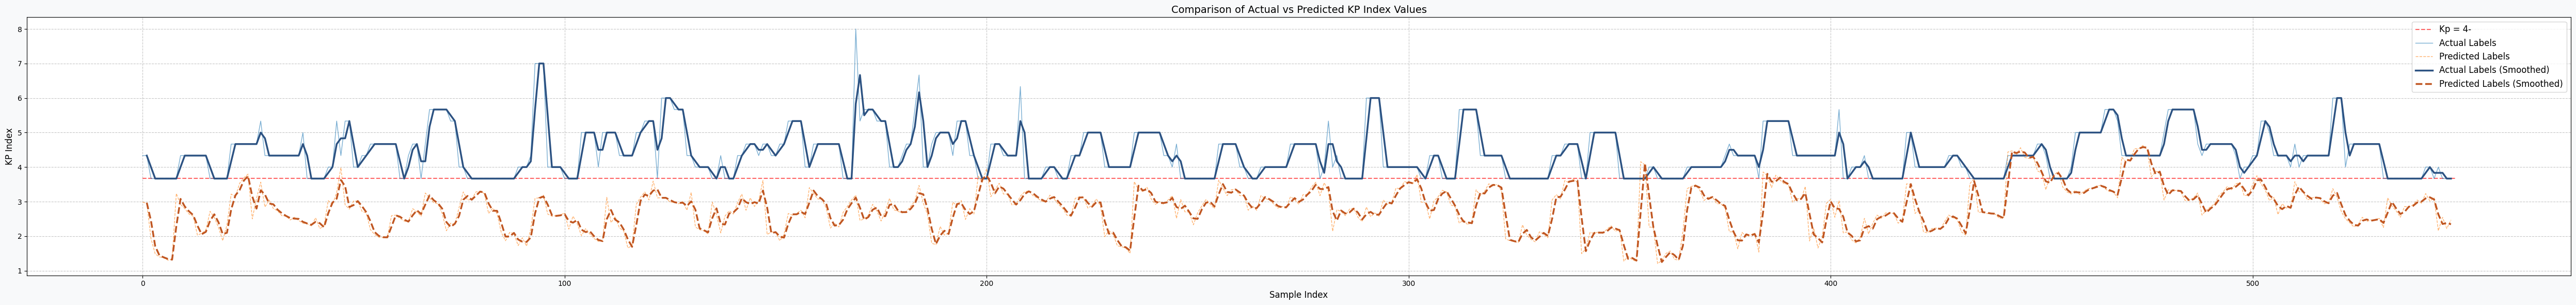

[np.float32(2.984375), np.float32(2.953125), np.float32(1.9296875), np.float32(1.484375), np.float32(1.3984375), np.float32(1.375), np.float32(1.3046875), np.float32(1.3359375), np.float32(3.234375), np.float32(2.921875), np.float32(2.796875), np.float32(2.640625), np.float32(2.578125), np.float32(2.03125), np.float32(2.078125), np.float32(2.171875), np.float32(2.71875), np.float32(2.546875), np.float32(2.25), np.float32(1.8671875), np.float32(2.328125), np.float32(3.21875), np.float32(3.140625), np.float32(3.53125), np.float32(3.6875), np.float32(3.796875), np.float32(2.5), np.float32(3.09375), np.float32(3.5625), np.float32(2.84375), np.float32(3.046875), np.float32(2.796875), np.float32(2.734375), np.float32(2.59375), np.float32(2.578125), np.float32(2.46875), np.float32(2.546875), np.float32(2.453125), np.float32(2.375), np.float32(2.359375), np.float32(2.296875), np.float32(2.53125), np.float32(2.21875), np.float32(2.296875), np.float32(3.03125), np.float32(2.90625), np.float32(3.

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  2.20450637063053


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2962335417717226


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.7898592756947105


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2928060943797208


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.542498109169136


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.4987744701093413


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.1239784937328445


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2831650395203635


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.7986065881354113


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3610741695060464


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6033950415488306


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.741166557018738


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.49276113647938197


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3982047545009857


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3920870074178524


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4895908804397533


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3229331629143258


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4407654257415177


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.28649299852450877


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4117702103920184


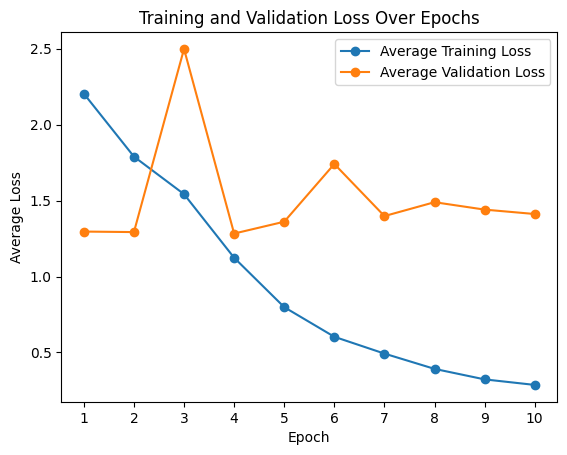

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.4118
RMSE: 1.1882
MSE: 1.4123
MAE: 0.9240
R²: -0.0877
R: 0.2645
True Skill Score: 0.4546
Accuracy: 0.8238
Precision: 0.4769
Recall: 0.0963
F1 Score: 0.1602


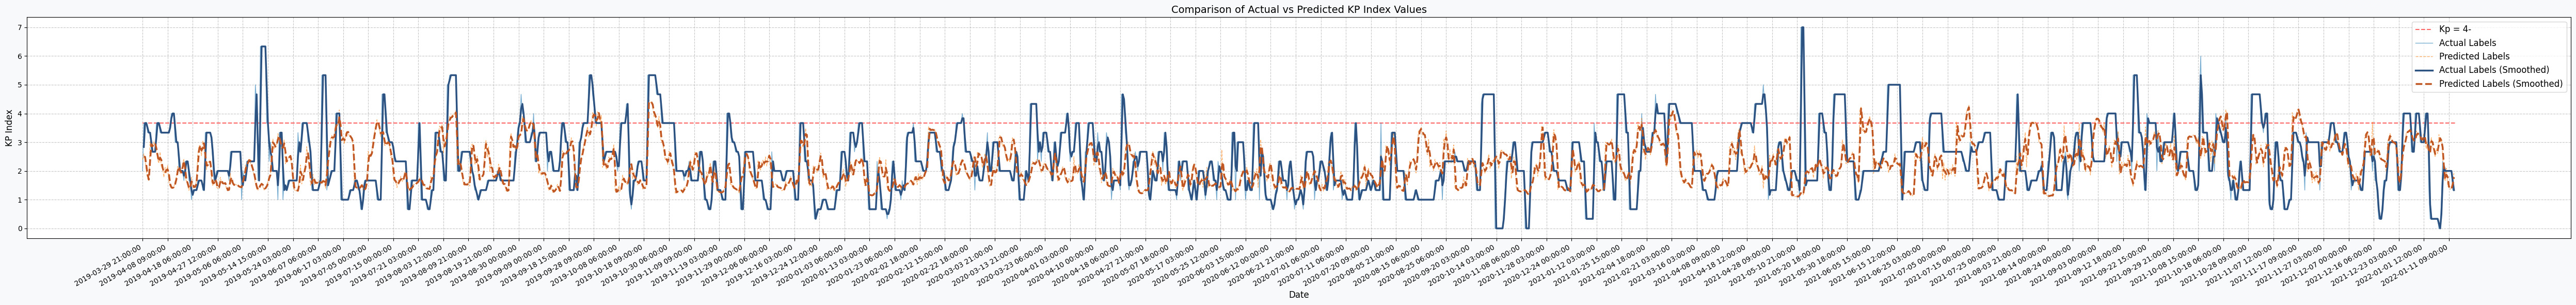

[np.float32(2.390625), np.float32(2.59375), np.float32(2.390625), np.float32(2.0), np.float32(1.75), np.float32(1.6484375), np.float32(3.015625), np.float32(2.84375), np.float32(2.875), np.float32(3.015625), np.float32(2.90625), np.float32(2.6875), np.float32(2.40625), np.float32(2.265625), np.float32(2.65625), np.float32(2.109375), np.float32(2.125), np.float32(1.78125), np.float32(2.125), np.float32(1.9296875), np.float32(2.1875), np.float32(1.6328125), np.float32(1.46875), np.float32(1.390625), np.float32(1.4296875), np.float32(1.4453125), np.float32(1.6328125), np.float32(1.7890625), np.float32(2.15625), np.float32(2.140625), np.float32(1.8984375), np.float32(1.984375), np.float32(2.28125), np.float32(2.40625), np.float32(1.7421875), np.float32(1.65625), np.float32(1.5), np.float32(1.3203125), np.float32(1.484375), np.float32(1.78125), np.float32(1.421875), np.float32(1.453125), np.float32(1.4375), np.float32(1.671875), np.float32(2.53125), np.float32(2.875), np.float32(2.890625), 

Testing Progress:   0%|          | 0/161 [00:00<?, ?it/s]

Average test loss: 3.7859
RMSE: 1.9457
MSE: 3.7859
MAE: 1.6779
R²: -7.7179
R: 0.0089


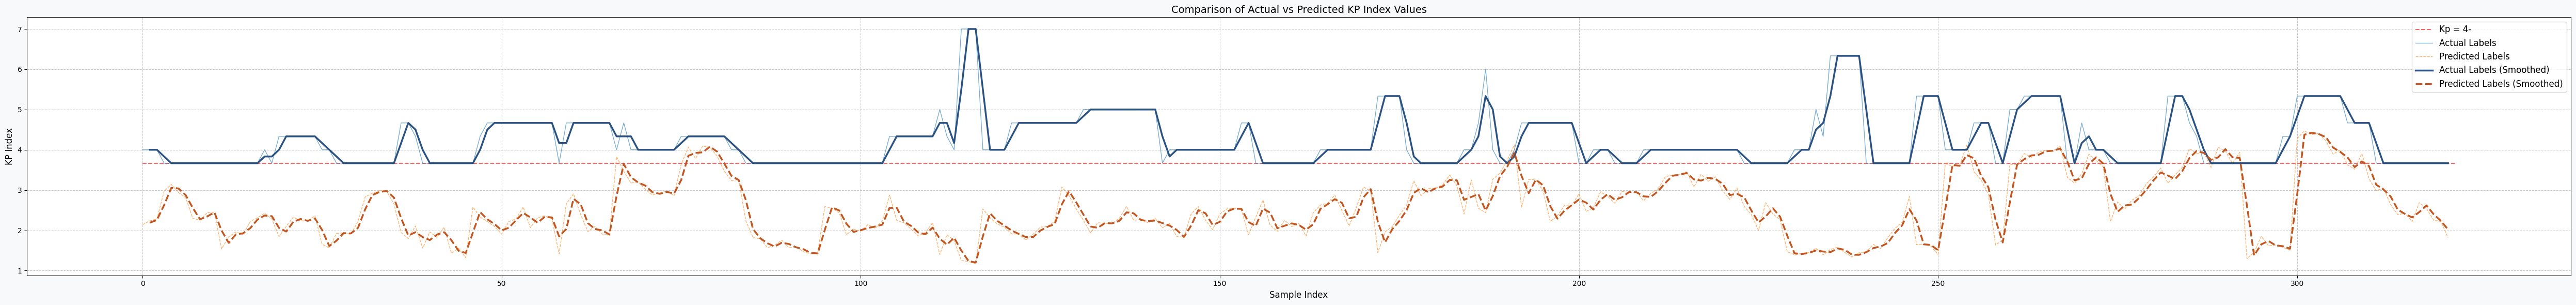

[np.float32(2.140625), np.float32(2.234375), np.float32(2.28125), np.float32(2.96875), np.float32(3.140625), np.float32(2.9375), np.float32(2.8125), np.float32(2.296875), np.float32(2.25), np.float32(2.4375), np.float32(2.453125), np.float32(1.5390625), np.float32(1.8359375), np.float32(1.9609375), np.float32(1.890625), np.float32(2.21875), np.float32(2.3125), np.float32(2.421875), np.float32(2.28125), np.float32(1.84375), np.float32(2.09375), np.float32(2.328125), np.float32(2.234375), np.float32(2.234375), np.float32(2.359375), np.float32(1.65625), np.float32(1.5625), np.float32(1.921875), np.float32(1.9375), np.float32(1.90625), np.float32(2.21875), np.float32(2.828125), np.float32(2.921875), np.float32(2.984375), np.float32(2.96875), np.float32(2.65625), np.float32(1.9453125), np.float32(1.796875), np.float32(2.109375), np.float32(1.5546875), np.float32(1.9609375), np.float32(1.828125), np.float32(2.078125), np.float32(1.4296875), np.float32(1.5546875), np.float32(1.3203125), np.fl

Training Progress: Epoch: 1:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.9690461193695357


Validation Progress: Epoch: 1:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  1.7354937838572757


Training Progress: Epoch: 2:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.4034182215719866


Validation Progress: Epoch: 2:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.173207741847694


Training Progress: Epoch: 3:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.0613574318071175


Validation Progress: Epoch: 3:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.616427390070711


Training Progress: Epoch: 4:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.775767556649094


Validation Progress: Epoch: 4:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.5288881158766396


Training Progress: Epoch: 5:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.6089754414183515


Validation Progress: Epoch: 5:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.2878379128460047


Training Progress: Epoch: 6:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.4891701496801229


Validation Progress: Epoch: 6:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.312886865212255


Training Progress: Epoch: 7:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.40387937558064585


Validation Progress: Epoch: 7:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.2683189193322373


Training Progress: Epoch: 8:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.34263253657961035


Validation Progress: Epoch: 8:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.6898760875279923


Training Progress: Epoch: 9:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.30348514160811163


Validation Progress: Epoch: 9:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.6256498646525404


Training Progress: Epoch: 10:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.2594744108913077


Validation Progress: Epoch: 10:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.447394262932009


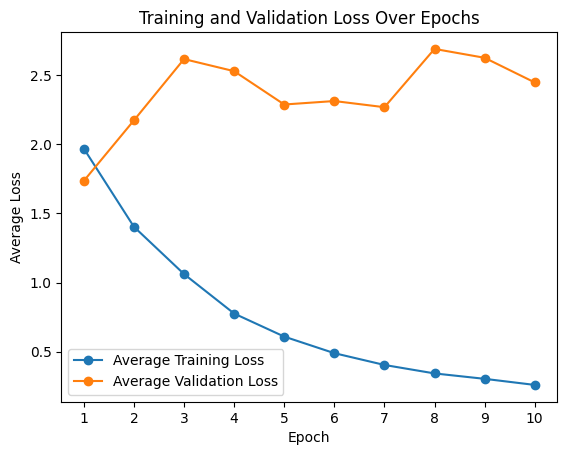

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/936 [00:00<?, ?it/s]

Average test loss: 2.4474
RMSE: 1.5644
MSE: 2.4474
MAE: 1.1726
R²: -0.3978
R: 0.1024
True Skill Score: 0.2960
Accuracy: 0.6485
Precision: 0.3930
Recall: 0.1285
F1 Score: 0.1936


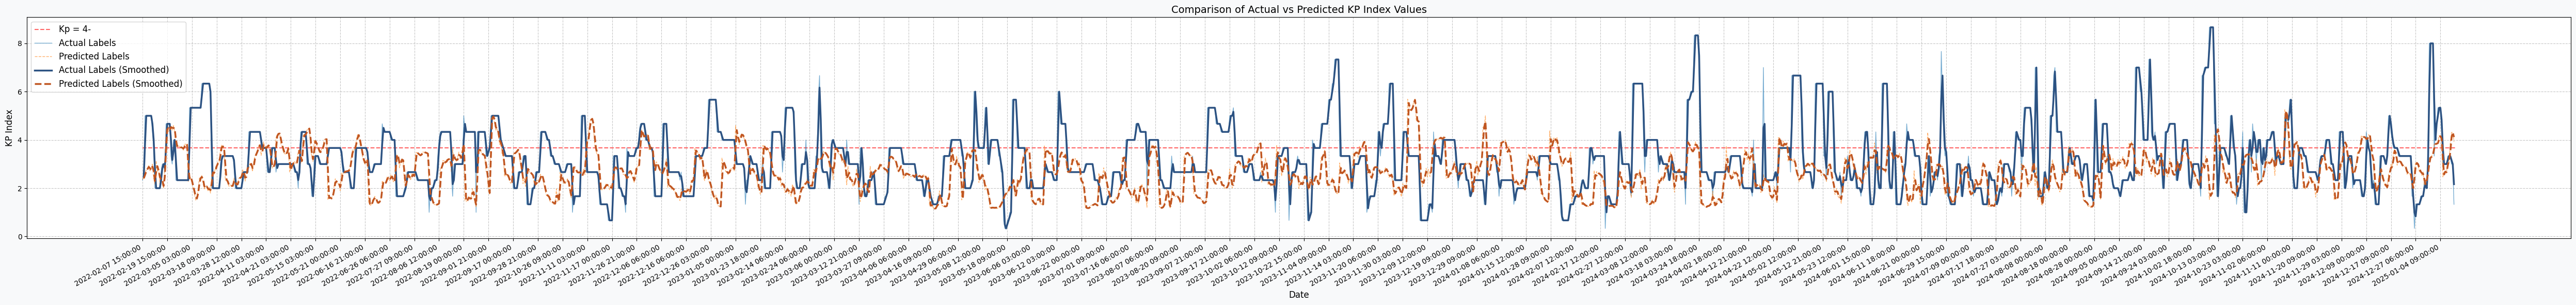

[np.float32(2.359375), np.float32(2.453125), np.float32(2.640625), np.float32(2.75), np.float32(2.828125), np.float32(2.9375), np.float32(2.71875), np.float32(2.796875), np.float32(3.0), np.float32(2.421875), np.float32(2.171875), np.float32(3.140625), np.float32(2.6875), np.float32(2.78125), np.float32(2.1875), np.float32(2.5), np.float32(2.171875), np.float32(2.015625), np.float32(2.921875), np.float32(4.21875), np.float32(4.65625), np.float32(4.34375), np.float32(4.46875), np.float32(4.59375), np.float32(4.40625), np.float32(4.59375), np.float32(4.34375), np.float32(3.703125), np.float32(3.78125), np.float32(3.75), np.float32(3.734375), np.float32(3.65625), np.float32(3.703125), np.float32(3.578125), np.float32(3.84375), np.float32(3.8125), np.float32(3.796875), np.float32(2.28125), np.float32(2.53125), np.float32(2.40625), np.float32(2.21875), np.float32(1.9765625), np.float32(1.7890625), np.float32(1.5078125), np.float32(1.6328125), np.float32(1.9453125), np.float32(2.421875), np.

Testing Progress:   0%|          | 0/308 [00:00<?, ?it/s]

Average test loss: 5.4581
RMSE: 2.3363
MSE: 5.4621
MAE: 1.9274
R²: -3.8373
R: -0.0542


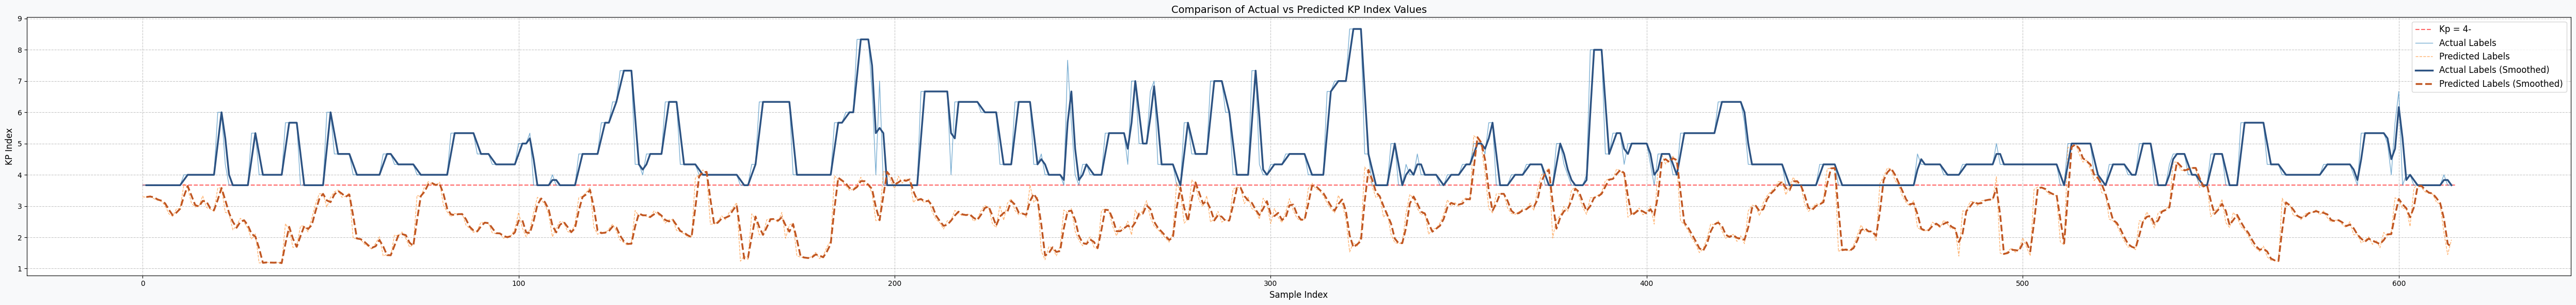

[np.float32(3.296875), np.float32(3.28125), np.float32(3.328125), np.float32(3.234375), np.float32(3.1875), np.float32(3.15625), np.float32(3.015625), np.float32(2.75), np.float32(2.671875), np.float32(2.90625), np.float32(2.921875), np.float32(3.703125), np.float32(3.578125), np.float32(3.09375), np.float32(2.96875), np.float32(3.0), np.float32(3.328125), np.float32(2.953125), np.float32(2.90625), np.float32(2.828125), np.float32(3.578125), np.float32(3.578125), np.float32(2.796875), np.float32(2.765625), np.float32(2.234375), np.float32(2.375), np.float32(2.609375), np.float32(2.484375), np.float32(2.28125), np.float32(1.9375), np.float32(2.109375), np.float32(1.1796875), np.float32(1.1875), np.float32(1.203125), np.float32(1.1796875), np.float32(1.1953125), np.float32(1.1953125), np.float32(1.15625), np.float32(2.4375), np.float32(2.234375), np.float32(1.671875), np.float32(1.71875), np.float32(2.359375), np.float32(2.359375), np.float32(2.171875), np.float32(2.609375), np.float32(3

In [16]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)

In [17]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
